In [1]:
import glob
import math
import obspy
import time
from obspy import UTCDateTime
from obspy.core import Stats
from obspy.clients.iris import Client
client = Client()
from matplotlib import pyplot as plt, patches
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import clear_output
import numpy as np
from sklearn.decomposition import PCA
from scipy import signal
from obspy.io.sac.sactrace import SACTrace
from obspy.io.sac.util import get_sac_reftime
import os
import glob
import numpy
from shutil import move
from obspy.taup import TauPyModel

In [2]:
def get_snr(st):
    #signal noise ratio
    TNoise1 = 15  # noise window_left before t1
    TNoise2 = 0   # noise window_right before t1
    TSignal1 = 5  # signal window_left before t1
    TSignal2 = 10 
    
    T = get_sac_reftime(st[0].stats.sac)
    # measure noise level
    tr = st.copy()
    tr.trim(starttime = T-TNoise1, endtime = T-TNoise2, fill_value=0)
    Noisamean = sum(abs(tr[0].data))/len(tr[0].data)
    # measure signal level
    tr = st.copy()
    tr.trim(starttime = T-TSignal1, endtime = T+TSignal2, fill_value=0)
    SignMax = max(abs(tr[0].data))
    # define the signal to noise value
    snr = SignMax/Noisamean
    return snr
def get_theoretical_arrival(st):
    model = TauPyModel(model=f"C:/Users/youzh/Documents/My documents(not synced)/sP_Workflow/Others/Path/Path/hk.npz")
    sachd = st[0].stats.sac
    distaz = client.distaz(sachd["stla"], sachd["stlo"], sachd["evla"], sachd["evlo"])
    gcarc = distaz['distance']
    
    if sachd["evdp"] < 0:
        arrival = model.get_travel_times(source_depth_in_km=0,distance_in_degree=gcarc, phase_list=["sPvmP"])
    else:                                  
        arrival = model.get_travel_times(source_depth_in_km=sachd["evdp"],distance_in_degree=gcarc, phase_list=["sPvmP"])
    if len(arrival) != 0:
        PTsPmP = float("{:.3f}".format(arrival[0].time))
    else: 
        PTsPmP = "nan" #change this later
    arrival = model.get_travel_times(source_depth_in_km=sachd["evdp"],distance_in_degree=gcarc, phase_list=["sPn"])
    if len(arrival) != 0:
        PTsPn = float("{:.3f}".format(arrival[0].time))
    else:
        PTsPn = "nan"
    return [PTsPmP, PTsPn]
def get_particle_motion_angle(st, idxp1, idxp2):
    maxp = max(max(abs(st[2].data[idxp1:idxp2])),max(abs(st[0].data[idxp1:idxp2])),max(abs(st[1].data[idxp1:idxp2])))
    zpm_p = st[2].data[idxp1:idxp2]/maxp
    rpm_p = st[0].data[idxp1:idxp2]/maxp
    X = np.column_stack((zpm_p, rpm_p))
    pca = PCA(n_components=1)
    pca.fit(X)
    angle = math.degrees(math.atan(pca.components_[0][1]/pca.components_[0][0]))
    #angle of Z vs R
    if angle < 0:
        angle1 = int("{:.0f}".format(180+angle))
    else:
        angle1 = int("{:.0f}".format(angle))
    return angle1

def get_spectrum(st, idxp1, idxp2):
    dt = st[2].stats.sac.delta
    z_p = st[2].data[idxp1:idxp2]
    (freqs,Pxx) = signal.periodogram(z_p, nfft=2**8, fs=1/dt)
    df1 = float("%.1f" % freqs[np.argmax(Pxx)])   
    return df1
def auto_filter(st, Tp, p_len, sPmP_len, sPn_len, SRsPmP, SRsPn, snr):
    #SR is search range
    snr_val = get_snr(st)
    if snr_val < snr:
        print("Signal Noise Ratio lower than threshold: ", snr_val)
        return False
    #calculate predicted arrival time for sPmP and sPn
    PTsPmP, PTsPn = get_theoretical_arrival(st)
    if PTsPmP == "nan":
        print("no predicted sPmP arrival")
        return False
    if PTsPn == "nan":
        print("no predicted sPn arrival")
    #set window for p 
    shift = st[0].stats.sac.o
    idxp1 = int((Tp+shift-st[0].stats.sac.b)/st[0].stats.delta) #what is st[0].stats.sac.b?
    idxp2 = int((Tp+shift+p_len-st[0].stats.sac.b)/st[0].stats.delta)
    # amplitude (maximum amplitude within the interval idxp1 and idxp2)
    zamp_p = max(abs(st[2].data[idxp1:idxp2]))
    # particle motion
    angle1 = get_particle_motion_angle(st, idxp1, idxp2)
      #spectrum
    df1 = get_spectrum(st, idxp1, idxp2)
    #list of stats
    UTsPmP = []
    PMA1 = []
    DFreq1 = []
    ratio11 = []
    ratio12 = []
    ratio13 = []
    ssr1 = []
    PMAr = []
    for cTsPmP in np.arange(PTsPmP-SRsPmP,PTsPmP+SRsPmP+sPmP_len/2,0.05):
        idxspm1 = int((cTsPmP +shift-st[0].stats.sac.b)/st[0].stats.delta)
        idxspm2 = int((cTsPmP +shift+sPmP_len-st[0].stats.sac.b)/st[0].stats.delta)
        # amplitude
        zamp_spm = (max(abs(st[2].data[idxspm1:idxspm2])))
        ramp_spm = (max(abs(st[0].data[idxspm1:idxspm2])))
        tamp_spm = (max(abs(st[1].data[idxspm1:idxspm2])))
        ratio11_temp = zamp_spm/zamp_p #amplitude ratio z/z
        ratio12_temp = zamp_spm/ramp_spm #amplitude ratio z/r
        ratio13_temp = ramp_spm/tamp_spm #amplitude ratio z/t
        # particle motion
        angle2 = get_particle_motion_angle(st, idxspm1, idxspm2)
        # spectrum
        df2 = get_spectrum(st, idxspm1, idxspm2)
        if (ratio11_temp > 0.5) and (ratio12_temp > 0.5) and (ratio13_temp > 1.0) and (abs(angle1-angle2)<20) and (abs(df1-df2)<1.5):
            UTsPmP.append(cTsPmP) #if the above conditions are met then the arrival time of the wave is stored in UTsPmP
            PMA1.append(angle2)
            DFreq1.append(df2)
            ratio11.append(ratio11_temp)
            ratio12.append(ratio12_temp)
            ratio13.append(ratio13_temp)
            ssr1.append(ratio11_temp * ratio12_temp * ratio13_temp)
    if str(PTsPn) != "nan":
        #lists
        UTsPn = []
        PMA2 = []
        DFreq2 = []
        ratio21 = []
        ratio22 = []
        ratio23 = []
        ssr2 = []
        if PTsPn+SRsPn+sPn_len > PTsPmP:
            spn_window2 = PTsPmP-sPn_len
        else:
            spn_window2=PTsPn+SRsPn
        for cTsPn in np.arange(PTsPn-SRsPn,spn_window2,0.05):
            idxspn1 = int((cTsPn+shift-st[0].stats.sac.b)/st[0].stats.delta)
            idxspn2 = int((cTsPn+shift+sPn_len-st[0].stats.sac.b)/st[0].stats.delta)
            # amplitude
            zamp_spn = (max(abs(st[2].data[idxspn1:idxspn2])))
            ramp_spn = (max(abs(st[0].data[idxspn1:idxspn2])))
            tamp_spn = (max(abs(st[1].data[idxspn1:idxspn2])))
            ratio21_temp = zamp_spn/zamp_p
            ratio22_temp = zamp_spn/ramp_spn
            ratio23_temp = ramp_spn/tamp_spn
            # particle motion
            angle3 = get_particle_motion_angle(st, idxspn1, idxspn2)
            # spectrum
            df3 = get_spectrum(st, idxspn1, idxspn2)
            # composite test
            if (ratio21_temp > 0.5) and (ratio22_temp > 0.5) and (ratio23_temp > 1.0) and (abs(angle1-angle3)<20) and (abs(df1-df3)<1.5):
                #print("something")
                UTsPn.append(cTsPn)
                PMA2.append(angle3)
                DFreq2.append(df3)
                ratio21.append(ratio21_temp)
                ratio22.append(ratio22_temp)
                ratio23.append(ratio23_temp)
                ssr2.append(ratio21_temp * ratio22_temp * ratio23_temp)
        if len(ssr2) > 0:
                indx2 = np.argmax(np.array(ssr2)/np.max(ssr2)+1*(1-abs(np.array(PMA2)-angle1)/angle1))
                TsPn_autorefined = UTsPn[indx2]
        else:
            TsPn_autorefined = PTsPn
    else:
        TsPn_autorefined = PTsPn
    if len(ssr1) > 0:
        indx1 = np.argmax(np.array(ssr1)/np.max(ssr1)+1*(1-abs(np.array(PMA1)-angle1)/angle1))
        TsPmP_autorefined = float("{:.3f}".format(UTsPmP[indx1]) )
    else: return False
    return [Tp, p_len, PTsPmP, TsPmP_autorefined, sPmP_len, PTsPn, sPn_len, TsPn_autorefined]

In [3]:
from step9 import *

ddir = f"C:/Users/youzh/Documents/My documents(not synced)/sP_Workflow"
data_sac = f"{ddir}/Download/SAC"
wdir = f"{ddir}/Download/Verified"

if not os.path.exists(wdir):
    os.mkdir(wdir)
    
import pandas as pd
def getEvtID(event):
    with open(f'{inpath}/arrivals.txt') as f:
        first_line = f.readline()
    evt_id = first_line.split()[0]
    return evt_id

['CI.WSS..BHR.SAC.bp.cut', 'CI.WSS..BHT.SAC.bp.cut', 'CI.WSS..BHZ.SAC.bp.cut']
3 Trace(s) in Stream:
CI.WSS..BHR | 2022-01-12T00:24:28.765356Z - 2022-01-12T00:26:53.715356Z | 100.0 Hz, 14496 samples
CI.WSS..BHT | 2022-01-12T00:24:28.765356Z - 2022-01-12T00:26:53.715356Z | 100.0 Hz, 14496 samples
CI.WSS..BHZ | 2022-01-12T00:24:28.765356Z - 2022-01-12T00:26:53.715356Z | 100.0 Hz, 14496 samples 13.64 26.010061


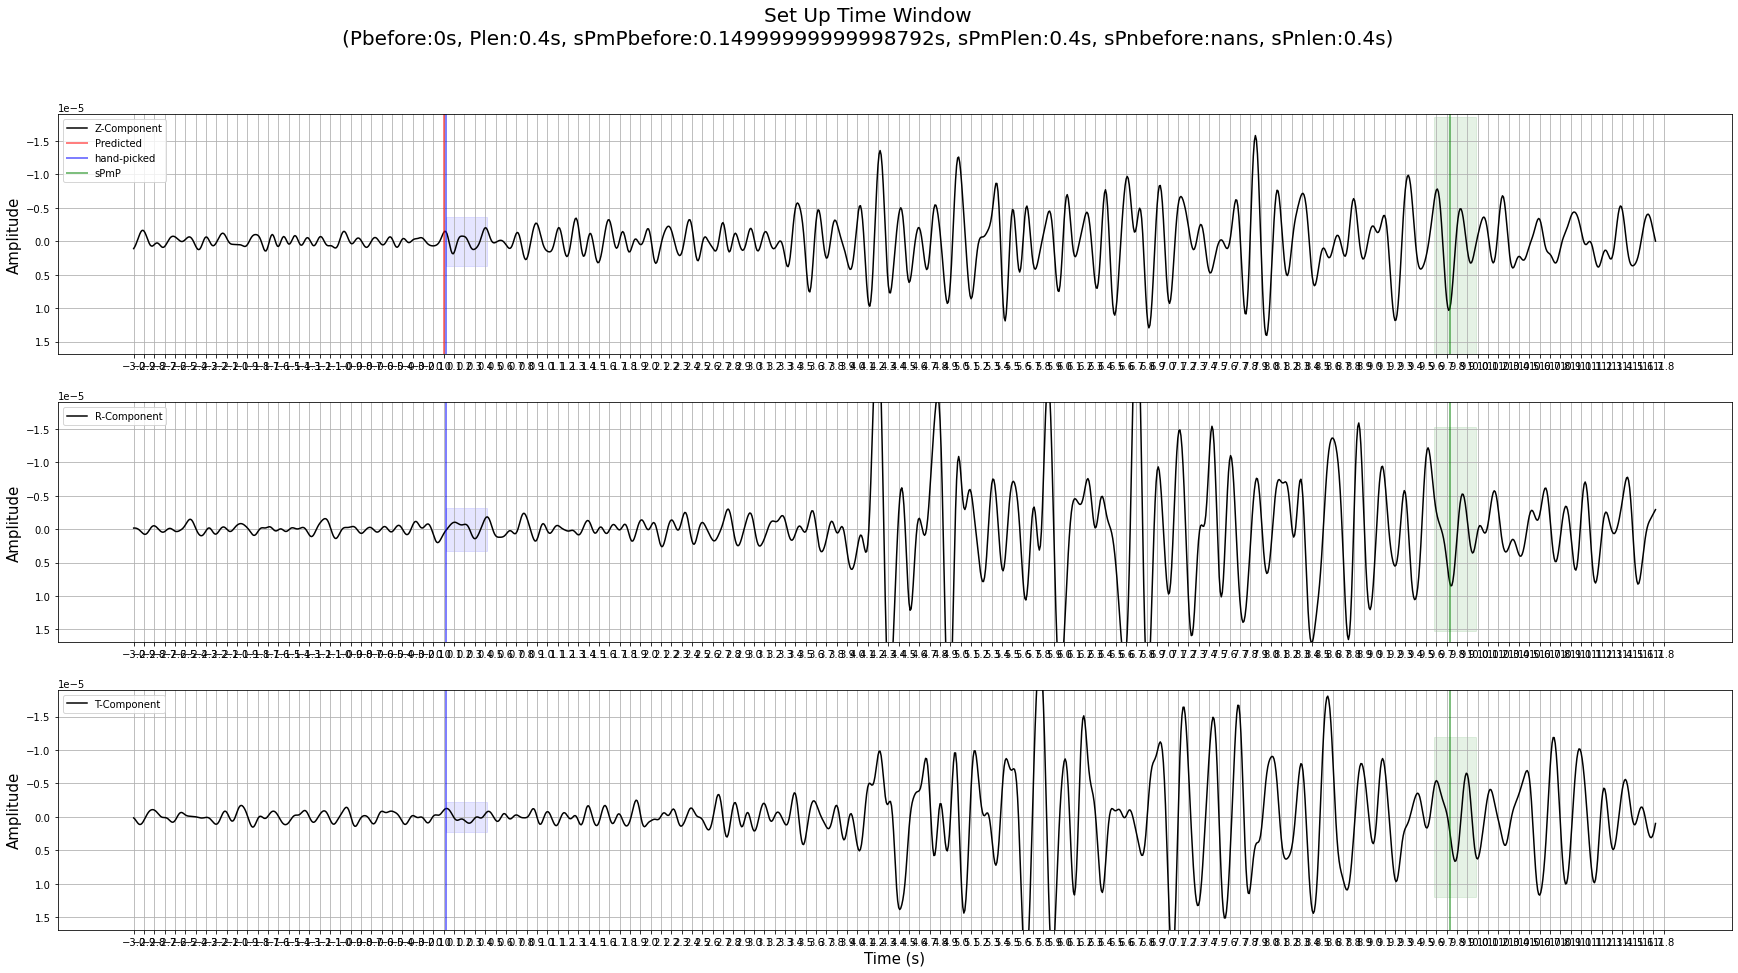

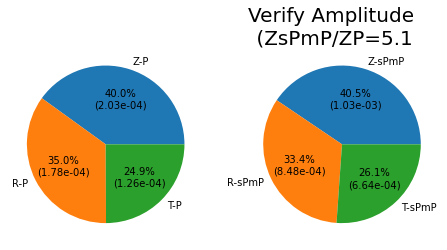

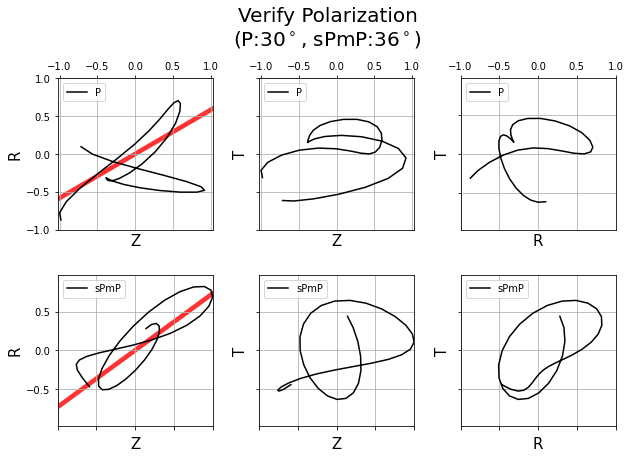

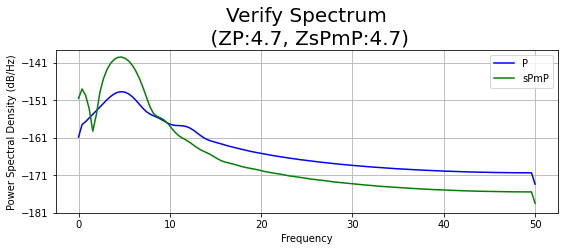

In [4]:
evtid =18

with open(f"{ddir}/Autojudge-large.info","r") as files:
    #print("something")
    for i,file in enumerate(files):
        if i == evtid - 1:
            
            evt = file.split()[1]
            sta = file.split()[2]
            Tp_handpicked = float(file.split()[4])
            Tp = Tp_handpicked
            p_length = float(file.split()[6])
              
            TsPmP = float(file.split()[8])
            TsPmp_autorefined = float(file.split()[10])
            sPmP_length = float(file.split()[12])
            
            TsPn = float(file.split()[14])
            TsPn_autorefined = float(file.split()[16])
            sPn_len = float(file.split()[18])
          
            inpath = os.path.join(data_sac, evt)
            os.chdir(inpath)
            print(glob.glob(f"{sta}*[RTZ].SAC.bp.cut"))

            st = obspy.read(f"{sta}*[RTZ].SAC.bp.cut")
            sachd = st[0].stats.sac
            print(st,sachd["evdp"],sachd["dist"])

        ### tune these parameters to set proper windows
            Tpbefore = 0
            Tplen = p_length
            Tspnbefore = -(TsPn_autorefined -TsPn)
            Tspnlen = sPn_len
            Tspmbefore = -(TsPmp_autorefined - TsPmP)
            Tspmlen = sPmP_length
            
            
            fig1 = set_window(st, Tp, TsPmP, TsPn, Twbefore=3, Twafter=2, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            fig2 = vef_amp(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            fig3 = vef_polaz(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            fig4 = vef_sptm(st, Tp, TsPmP, TsPn, PN=2**8, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            
            

In [47]:
sachd = st[0].stats.sac
print(st,sachd["evdp"],sachd["dist"])
model = TauPyModel(model=f"C:/Users/youzh/Documents/My documents(not synced)/sP_Workflow/Others/Path/Path/hk.npz")
sachd = st[0].stats.sac
distaz = client.distaz(sachd["stla"], sachd["stlo"], sachd["evla"], sachd["evlo"])
gcarc = distaz['distance']
arrival = model.get_travel_times(source_depth_in_km=sachd["evdp"],distance_in_degree=gcarc, phase_list=["p","sPn", "P","s", "S"])
print(arrival)

3 Trace(s) in Stream:
CI.LMR2..BHR | 2022-01-08T06:21:01.654213Z - 2022-01-08T06:23:09.064213Z | 100.0 Hz, 12742 samples
CI.LMR2..BHT | 2022-01-08T06:21:01.654213Z - 2022-01-08T06:23:09.064213Z | 100.0 Hz, 12742 samples
CI.LMR2..BHZ | 2022-01-08T06:21:01.654213Z - 2022-01-08T06:23:09.064213Z | 100.0 Hz, 12742 samples 1.8 130.8819
15 arrivals
	P phase arrival at 21.594 seconds
	P phase arrival at 21.608 seconds
	P phase arrival at 21.881 seconds
	P phase arrival at 22.339 seconds
	P phase arrival at 22.589 seconds
	sPn phase arrival at 23.089 seconds
	p phase arrival at 23.816 seconds
	P phase arrival at 23.865 seconds
	S phase arrival at 37.376 seconds
	S phase arrival at 37.401 seconds
	S phase arrival at 37.873 seconds
	S phase arrival at 38.676 seconds
	S phase arrival at 39.098 seconds
	s phase arrival at 41.202 seconds
	S phase arrival at 41.286 seconds


In [52]:
model2 = TauPyModel(model="iasp91")
arrival = model2.get_travel_times(source_depth_in_km=sachd["evdp"],distance_in_degree=gcarc, phase_list=["p","sPn"])
print(arrival)

2 arrivals
	p phase arrival at 22.590 seconds
	sPn phase arrival at 24.214 seconds


In [43]:
sachd = st[0].stats.sac
print(st,sachd["evdp"],sachd["dist"])

3 Trace(s) in Stream:
CI.LMR2..BHR | 2022-01-08T06:21:01.654213Z - 2022-01-08T06:23:09.064213Z | 100.0 Hz, 12742 samples
CI.LMR2..BHT | 2022-01-08T06:21:01.654213Z - 2022-01-08T06:23:09.064213Z | 100.0 Hz, 12742 samples
CI.LMR2..BHZ | 2022-01-08T06:21:01.654213Z - 2022-01-08T06:23:09.064213Z | 100.0 Hz, 12742 samples 1.8 130.8819


[21.79028434753418, 0.7, 23.309, 23.359, 0.4, 23.089, 0.3, 22.989000000000008]
TsPn if statement: 23.089 <class 'float'> nan


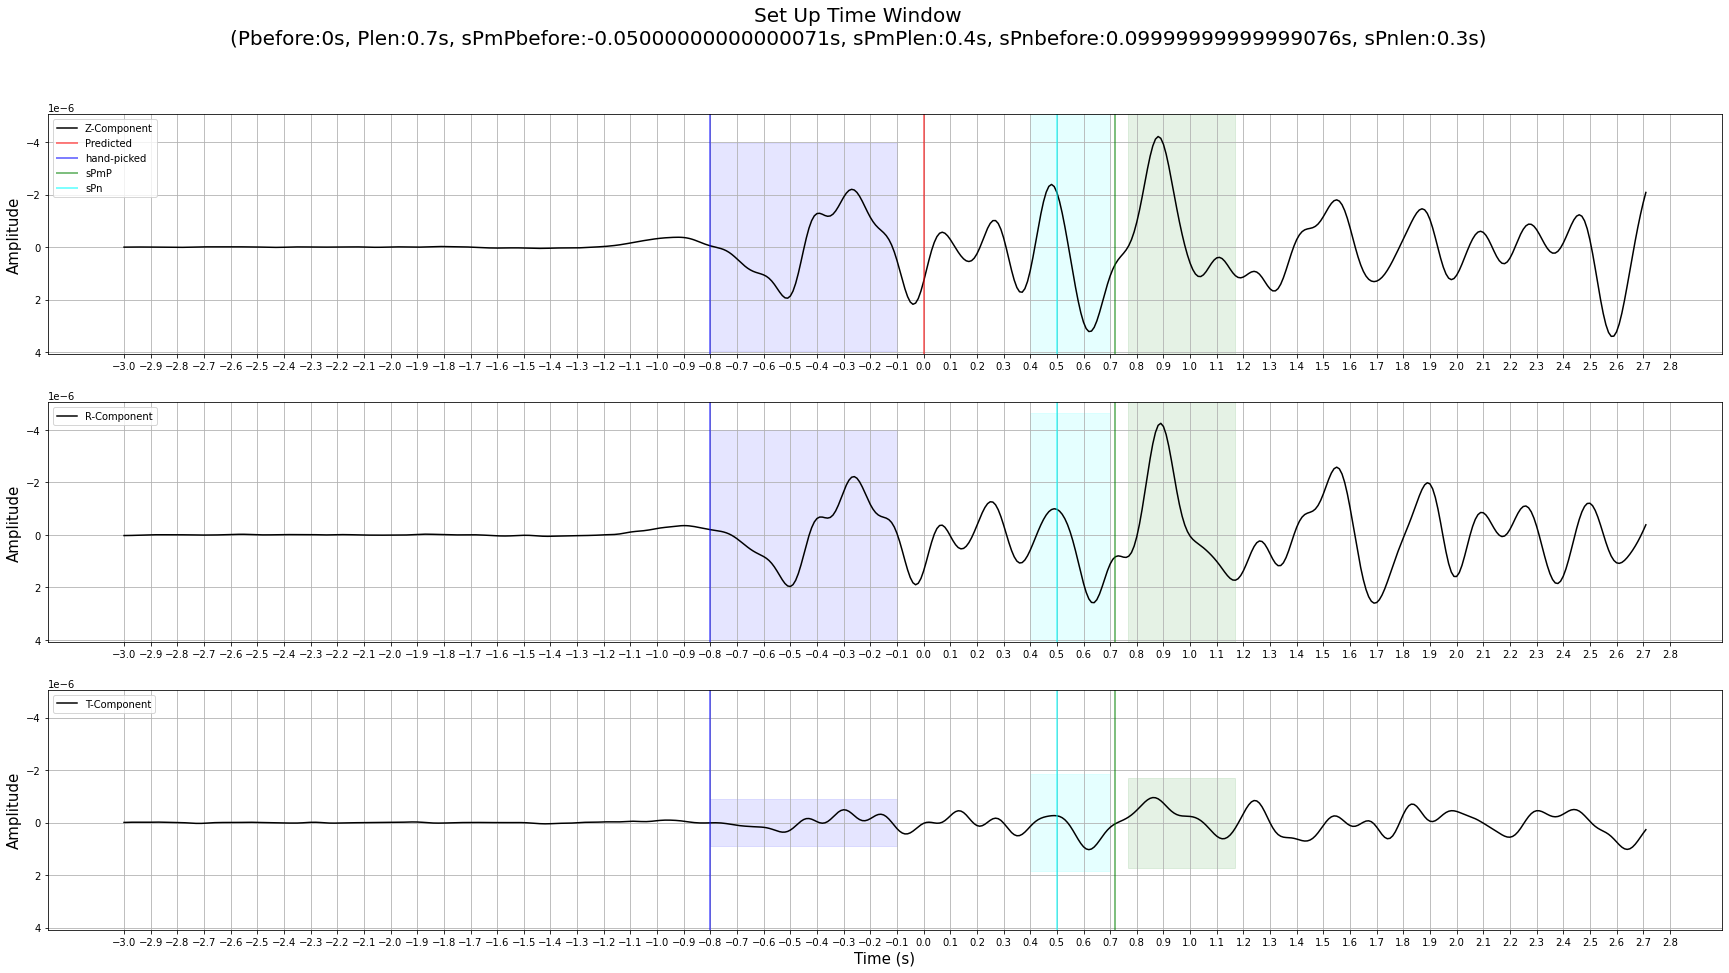

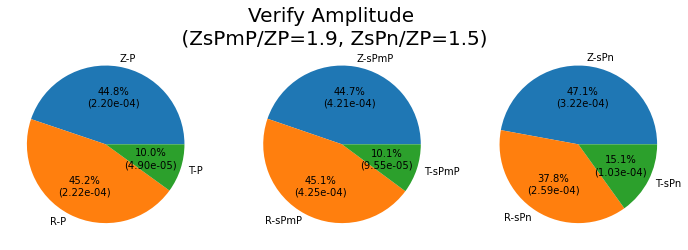

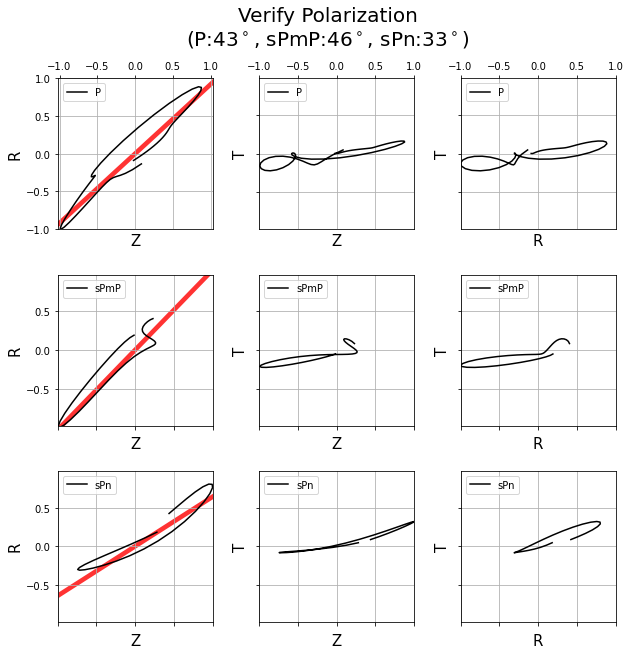

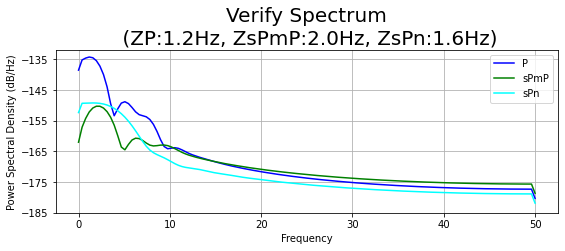

In [44]:
st = obspy.read(f"C:/Users/youzh/Documents/My documents(not synced)/sP_Workflow/Download/SAC/20220108062131650/CI.LMR2*[RTZ].SAC.bp.cut")
filtered_vals = auto_filter(st, -0.8-1*(st[0].stats.sac.o), 0.7, 0.4, 0.3, 0, 0.7, 15)
Tp, p_len, PTsPmP, TsPmP_autorefined, sPmP_len, PTsPn, sPn_len, TsPn_autorefined = filtered_vals
print(filtered_vals)
plot_graphs(st, Tp, PTsPmP, PTsPn, p_len, sPmP_len, sPn_len, TsPmP_autorefined, TsPn_autorefined)

In [5]:
def plot_graphs(st, Tp, TsPmP, TsPn, Tplen, Tspmlen, Tspnlen, TsPmp_autorefined, TsPn_autorefined):
    Tpbefore = 0
    Tspnbefore = -(float(TsPn_autorefined) -float(TsPn))
    Tspmbefore = -(float(TsPmp_autorefined) - float(TsPmP))
    fig1 = set_window(st, Tp, TsPmP, TsPn, Twbefore=3, Twafter=2, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
    fig2 = vef_amp(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
    fig3 = vef_polaz(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
    fig4 = vef_sptm(st, Tp, TsPmP, TsPn, PN=2**8, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)


no predicted sPn arrival
[10.788, 0.2, 17.992, 18.042, 0.3, 'nan', 0.2, 'nan']
3 Trace(s) in Stream:
CI.MWC..BHR | 2022-01-12T00:24:28.774480Z - 2022-01-12T00:26:47.404480Z | 100.0 Hz, 13864 samples
CI.MWC..BHT | 2022-01-12T00:24:28.774480Z - 2022-01-12T00:26:47.404480Z | 100.0 Hz, 13864 samples
CI.MWC..BHZ | 2022-01-12T00:24:28.774480Z - 2022-01-12T00:26:47.404480Z | 100.0 Hz, 13864 samples 13.64 64.54148


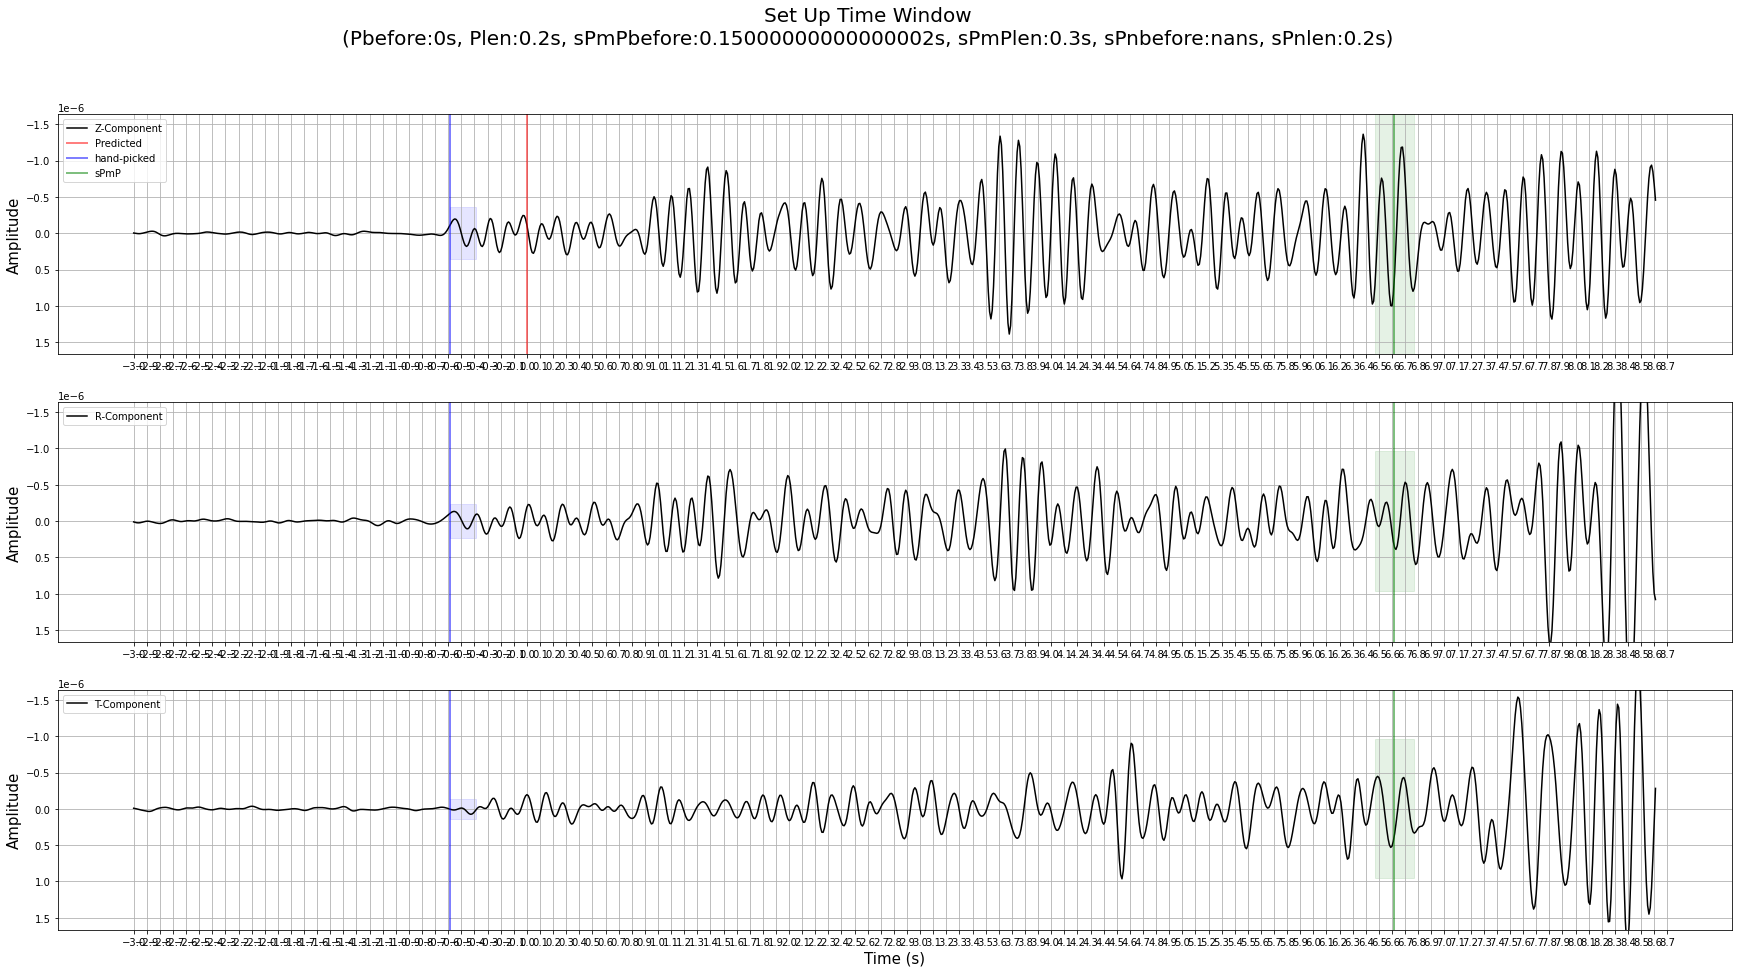

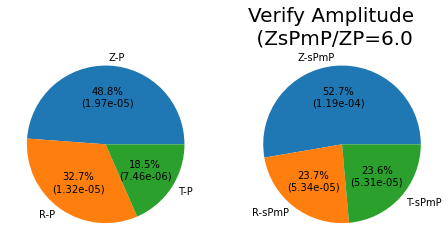

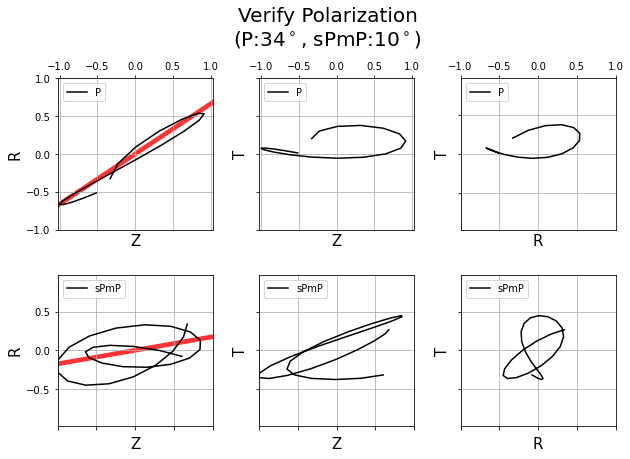

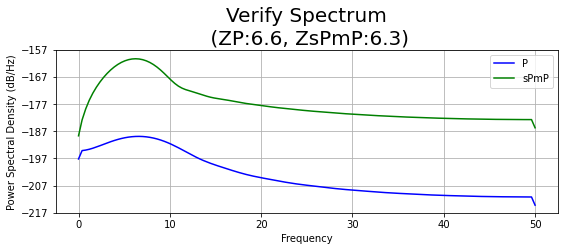

In [8]:
filtered_vals = auto_filter(st, Tp, 0.2, 0.3, 0.2, 0.8, 0.5, 15)
    #st, p arrival time, p wave length, sPmP wave length, sPn wave length, search range for sPmP, search range for sPn, signal noise ratio
print(filtered_vals)
if filtered_vals != False:
    
    Tp, p_len, PTsPmP, TsPmP_autorefined, sPmP_len, PTsPn, sPn_len, TsPn_autorefined = filtered_vals
    f = open(f"C:/Users/youzh/Documents/My documents(not synced)/sP_Workflow/temp_judge.info","w")
    f.write("evt: {} {} Tp_handpicked: {} p_length: {} TsPmP: {} TsPmp_autorefined: {} sPmP_length {} \
         TsPn: {} TsPn_autorefined: {} sPn_len: {} \n"\
             .format(evt, sta, Tp, p_len, PTsPmP, TsPmP_autorefined, sPmP_len, PTsPn, TsPn_autorefined, sPn_len))
    f.close()
    with open(f"{ddir}/temp_judge.info","r") as files:
        
        for i,file in enumerate(files):

                evt = file.split()[1]
                sta = file.split()[2]
                Tp_handpicked = float(file.split()[4])
                Tp = Tp_handpicked
                p_length = float(file.split()[6])

                TsPmP = float(file.split()[8])
                TsPmp_autorefined = float(file.split()[10])
                sPmP_length = float(file.split()[12])

                TsPn = float(file.split()[14])
                TsPn_autorefined = float(file.split()[16])
                sPn_len = float(file.split()[18])

                inpath = os.path.join(data_sac, evt)
                os.chdir(inpath)
                #print(glob.glob(f"{sta}*[RTZ].SAC.bp.cut"))

                st = obspy.read(f"{sta}*[RTZ].SAC.bp.cut")
                sachd = st[0].stats.sac
                print(st,sachd["evdp"],sachd["dist"])

            ### tune these parameters to set proper windows
                Tpbefore = 0
                Tplen = p_length
                Tspnbefore = float("{:.3f}".format(-(TsPn_autorefined -TsPn)))
                Tspnlen = sPn_len
                
                Tspmbefore = float("{:.3f}".format(-(TsPmp_autorefined - TsPmP)))+0.2
                Tspmlen = sPmP_length

                fig1 = set_window(st, Tp, TsPmP, TsPn, Twbefore=3, Twafter=2, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
                fig2 = vef_amp(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
                fig3 = vef_polaz(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
                fig4 = vef_sptm(st, Tp, TsPmP, TsPn, PN=2**8, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)


In [38]:
quality = input("overall score: a(4 checks), b(3 checks), c(2 checks), f(skip)")
if quality == "a" or quality == "b" or quality == "c":
    record = open(f"{ddir}./record.txt", "a")
    evt_id = getEvtID(evt)
    TsPmP = TsPmP-Tspmbefore
    TsPn = TsPn-Tspnbefore
    if str(TsPn) == "nan":
        Tspnlen = "nan"
    record.write(f" {evt_id} {evt} {sta} {Tp} {Tplen} {TsPmP} {Tspmlen} {TsPn} {Tspnlen} {quality}\n")
    record.close()

overall score: a(4 checks), b(3 checks), c(2 checks), f(skip)b


In [ ]:
with open(f"{ddir}/record.txt","r") as files:
        
    for i,file in enumerate(files):

            evt = file.split()[1]
            sta = file.split()[2]
            Tp_handpicked = float(file.split()[4])
            Tp = Tp_handpicked
            p_length = float(file.split()[4])

            TsPmP = float(file.split()[5])
            TsPmp_autorefined = float(file.split()[10])
            sPmP_length = float(file.split()[12])

            TsPn = float(file.split()[14])
            TsPn_autorefined = float(file.split()[16])
            sPn_len = float(file.split()[18])

            inpath = os.path.join(data_sac, evt)
            os.chdir(inpath)
            #print(glob.glob(f"{sta}*[RTZ].SAC.bp.cut"))

            st = obspy.read(f"{sta}*[RTZ].SAC.bp.cut")
            sachd = st[0].stats.sac
            print(st,sachd["evdp"],sachd["dist"])

        ### tune these parameters to set proper windows
            Tpbefore = 0
            Tplen = p_length
            Tspnbefore = float("{:.3f}".format(-(TsPn_autorefined -TsPn)))
            Tspnlen = sPn_len

            Tspmbefore = float("{:.3f}".format(-(TsPmp_autorefined - TsPmP)))
            Tspmlen = sPmP_length

            fig1 = set_window(st, Tp, TsPmP, TsPn, Twbefore=3, Twafter=2, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            fig2 = vef_amp(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            fig3 = vef_polaz(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            fig4 = vef_sptm(st, Tp, TsPmP, TsPn, PN=2**8, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
